# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'binary_model.keras'

## Data Ingestion

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(r'Datasets\Aircraft Sensor Values\PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(r'Datasets\Aircraft Sensor Values\PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(r'Datasets\Aircraft Sensor Values\PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Data Preprocessing

In [ ]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

## LSTM

In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
75/75 - 7s - 90ms/step - accuracy: 0.8972 - loss: 0.2424 - val_accuracy: 0.9373 - val_loss: 0.1742
Epoch 2/100
75/75 - 1s - 13ms/step - accuracy: 0.9593 - loss: 0.1006 - val_accuracy: 0.9629 - val_loss: 0.0876
Epoch 3/100
75/75 - 1s - 14ms/step - accuracy: 0.9692 - loss: 0.0729 - val_accuracy: 0.9910 - val_loss: 0.0362
Epoch 4/100
75/75 - 1s - 9ms/step - accuracy: 0.9667 - loss: 0.0803 - val_accuracy: 0.9527 - val_loss: 0.0971
Epoch 5/100
75/75 - 1s - 9ms/step - accuracy: 0.9709 - loss: 0.0710 - val_accuracy: 0.9783 - val_loss: 0.0557
Epoch 6/100
75/75 - 1s - 9ms/step - accuracy: 0.9720 - loss: 0.0653 - val_accuracy: 0.9527 - val_loss: 0.0915
Epoch 7/100
75/75 - 1s - 17ms/step - accuracy: 0.9676 - loss: 0.0769 - val_accuracy: 0.9859 - val_loss: 0.0352
Epoch 8/100
75/75 - 1s - 9ms/step - accuracy: 0.9728 - loss: 0.0640 - val_accuracy: 0.9795 - val_loss: 0.0512
Epoch 9/100
75/75 - 1s - 9ms/step - accuracy: 0.9749 - loss: 0.0581 - val_accuracy: 0.9655 - val_loss: 0.0733
E

## Model Evaluation on Test set

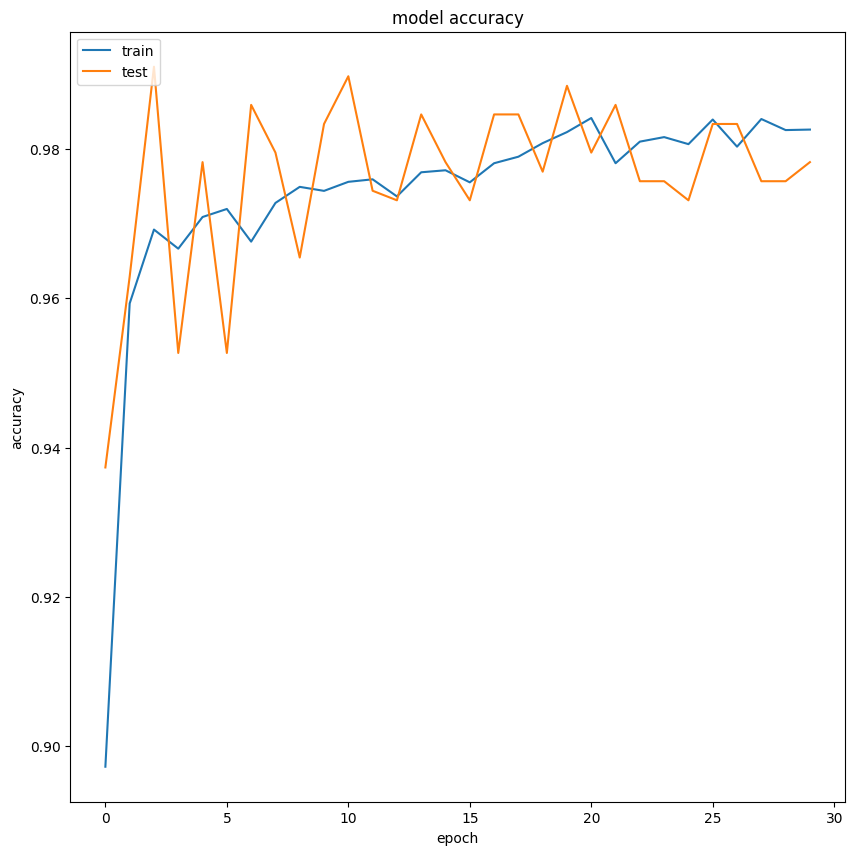

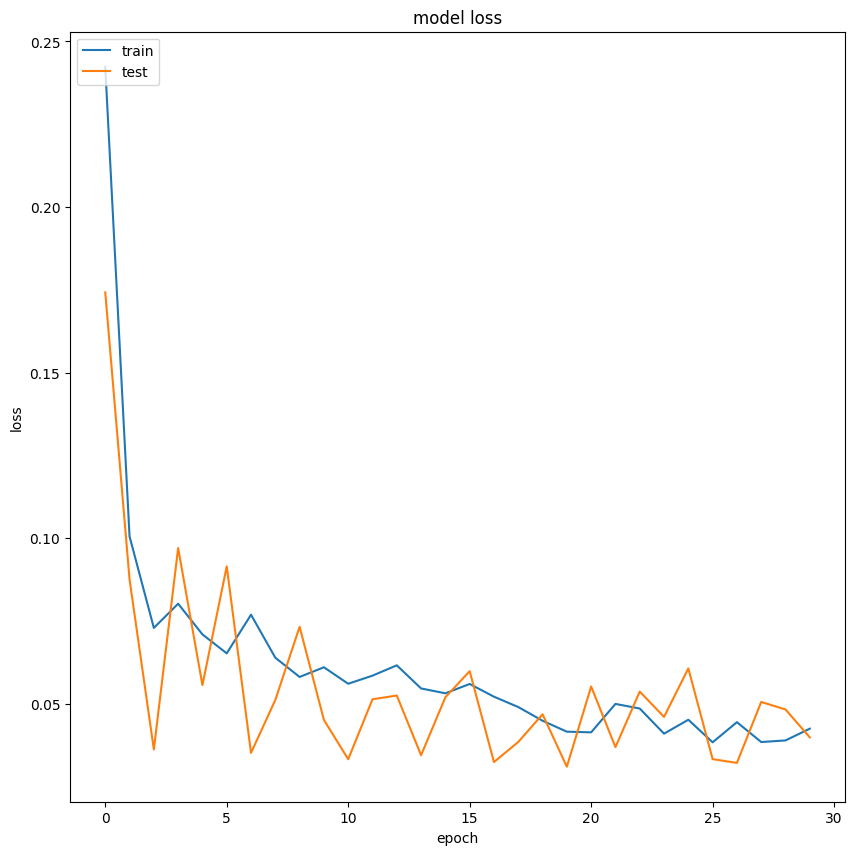

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - loss: 0.0392
Accurracy: 0.9809992909431458
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12400   131]
 [  166  2934]]
precision =  0.9572593800978793 
 recall =  0.9464516129032258


In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
# y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
# y_pred = np.argmax(model.predict(seq_array) > 0.5).astype("int32")
predictions = model.predict(seq_array, verbose=1, batch_size=200)
y_pred = np.argmax(predictions, axis=1)
y_pred = (predictions > 0.5).astype("int32").flatten()
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

3/3 - 0s - 144ms/step - accuracy: 0.9677 - loss: 0.0647
Accurracy: 0.9677419066429138
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 2 23]]
Precision:  0.9583333333333334 
 Recall:  0.92 
 F1-score: 0.9387755102040817


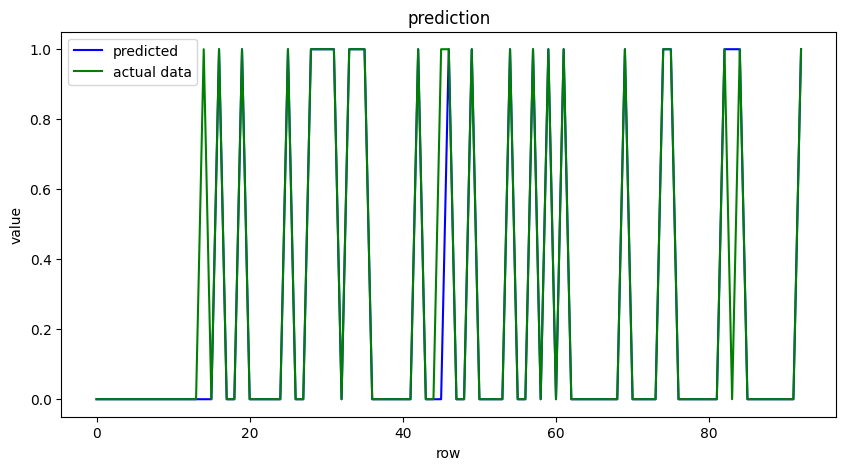

In [ ]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
# y_pred_test = estimator.predict_classes(seq_array_test_last)
predictions_test = estimator.predict(seq_array_test_last)
y_pred_test = np.argmax(predictions_test, axis=1)
y_pred_test = (predictions_test > 0.5).astype("int32").flatten()
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# References


- [1] Deep Learning for Predictive Maintenance https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb
- [2] Predictive Maintenance: Step 2A of 3, train and evaluate regression models https://gallery.cortanaintelligence.com/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2
- [3] A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan), NASA Ames Research Center, Moffett Field, CA
- [4] Understanding LSTM Networks http://colah.github.io/posts/2015-08-Understanding-LSTMs/

